In [17]:
from src.network.customics import CustOMICS
from src.tools.prepare_dataset import prepare_dataset
from src.tools.utils import get_sub_omics_df, get_common_samples
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import torch

omics_df = {#'protein': pd.read_csv('toy_data/protein.txt', sep='\t', index_col=0, header=0).T,
            'gene_exp': pd.read_csv('/Users/jacksalici/Documents/University/2024-1_AIxBioInformatics/Project/CustoMics/TCGA-OV.htseq_fpkm.tsv', sep='\t', index_col=0, header=0).T,
            'methyl': pd.read_csv('/Users/jacksalici/Documents/University/2024-1_AIxBioInformatics/Project/CustoMics/TCGA-OV.methylation27.tsv', sep='\t', index_col=0, header=0).T
            }
clinical_df = pd.read_csv('/Users/jacksalici/Documents/University/2024-1_AIxBioInformatics/Project/CustoMics/TCGA-OV.survival.tsv', sep='\t', index_col=0, header=0)



In [18]:
for name, omics in omics_df.items():
    omics.dropna(inplace=True, how='all', axis=1)
    omics.fillna(value=0, inplace=True)   

In [19]:
omics_df

{'gene_exp': Ensembl_ID        ENSG00000242268.2  ENSG00000270112.3  ENSG00000167578.15  \
 TCGA-23-1120-01A           0.000000           0.057584            1.595397   
 TCGA-29-1695-01A           0.118122           0.006816            2.562768   
 TCGA-61-2003-01A           0.000000           0.058252            2.685684   
 TCGA-13-1404-01A           0.000000           0.029621            1.760746   
 TCGA-23-1027-01A           0.000000           0.001993            2.374482   
 ...                             ...                ...                 ...   
 TCGA-23-2078-01A           0.844446           0.095507            1.655006   
 TCGA-09-1666-01A           0.206684           0.013154            1.922098   
 TCGA-29-1777-01A           0.000000           0.023142            1.524814   
 TCGA-61-2110-01A           0.000000           0.004686            2.215695   
 TCGA-29-1776-01A           0.000000           0.027489            1.630033   
 
 Ensembl_ID        ENSG00000273842.1  

In [20]:
lt_samples = get_common_samples([*list(omics_df.values()), clinical_df])
print(f"n of sample: {len(lt_samples)}")

samples_train, samples_test = train_test_split(lt_samples, test_size=0.2)
samples_train, samples_val = train_test_split(samples_train, test_size=0.2)


omics_train = get_sub_omics_df(omics_df, samples_train)
omics_val = get_sub_omics_df(omics_df, samples_val)
omics_test = get_sub_omics_df(omics_df, samples_test)


x_dim = [omics_df[omic_source].shape[1] for omic_source in omics_df.keys()]


n of sample: 371


In [26]:
batch_size = 32
n_epochs = 15
device = torch.device('cpu')
label = 'OS'
event = 'OS'
surv_time = 'OS.time'

task = 'survival'
sources = omics_df.keys()

hidden_dim = [512, 256]
central_dim = [512, 256]
rep_dim = 256
latent_dim = 256
num_classes = 3
dropout = 0.45
beta = 1
lambda_classif = 5
classifier_dim = [128, 64]
lambda_survival = 5
survival_dim = [128,32]

source_params = {}
central_params = {'hidden_dim': central_dim, 'latent_dim': latent_dim, 'norm': True, 'dropout': dropout, 'beta': beta}
classif_params = {'n_class': num_classes, 'lambda': lambda_classif, 'hidden_layers': classifier_dim, 'dropout': dropout}
surv_params = {'lambda': lambda_survival, 'dims': survival_dim, 'activation': 'SELU', 'l2_reg': 1e-2, 'norm': True, 'dropout': dropout}
for i, source in enumerate(sources):
    source_params[source] = {'input_dim': x_dim[i], 'hidden_dim': hidden_dim, 'latent_dim': rep_dim, 'norm': True, 'dropout': 0.2}
train_params = {'switch': 5, 'lr': 5e-2}


In [27]:
model = CustOMICS(source_params=source_params, central_params=central_params, classif_params=classif_params,
                        surv_params=surv_params, train_params=train_params, device=device).to(device)
print('Number of Parameters: ', model.get_number_parameters())

Number of Parameters:  67572184


In [28]:
model.fit(omics_train=omics_train, clinical_df=clinical_df, label=label, event=event, surv_time=surv_time,
            omics_val=omics_val, batch_size=batch_size, n_epochs=n_epochs, verbose=True)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


	Epoch 1 complete! 	Average Loss Train :  1.0068740621209145 	Average Loss Val :  4.563439607620239
	Epoch 2 complete! 	Average Loss Train :  0.7736152857542038 	Average Loss Val :  0.865694522857666
	Epoch 3 complete! 	Average Loss Train :  0.7274018079042435 	Average Loss Val :  0.6459679007530212
	Epoch 4 complete! 	Average Loss Train :  0.699585072696209 	Average Loss Val :  0.6444719731807709
	Epoch 5 complete! 	Average Loss Train :  0.6842915043234825 	Average Loss Val :  0.649602621793747
	Epoch 6 complete! 	Average Loss Train :  1.4783950671553612 	Average Loss Val :  0.7636726498603821
	Epoch 7 complete! 	Average Loss Train :  0.5737253129482269 	Average Loss Val :  0.37966687977313995
	Epoch 8 complete! 	Average Loss Train :  0.41038450226187706 	Average Loss Val :  0.35161419212818146
	Epoch 9 complete! 	Average Loss Train :  0.38750695437192917 	Average Loss Val :  0.33724410831928253
	Epoch 10 complete! 	Average Loss Train :  0.36934104561805725 	Average Loss Val :  0.3313

In [29]:
model.evaluate(omics_test=omics_test, clinical_df=clinical_df, label=label, event=event, surv_time=surv_time,
                task=task, batch_size=1024, plot_roc=False)

0.547646383467279

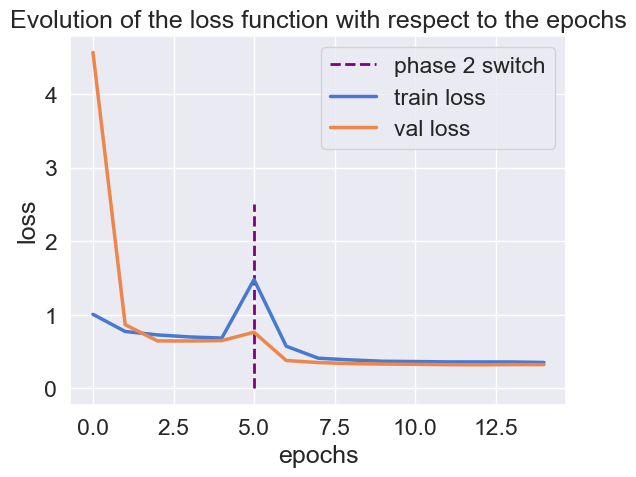

In [30]:
model.plot_loss()
